from azureml.core import Workspace

subscription_id = '9d86bb9e-5ee7-4865-82f0-b658cd30da1b'
resource_group = 'MCC'
workspace_name = 'ProductML'

workspace = Workspace(subscription_id, resource_group, workspace_name)

#create a workspace config file to reference you workspace without needing to specify the identifying variables
workspace.write_config(path="./", file_name="ws_config.json")

## Connect to Workspace

In [1]:
#call workspace from config file in another environment
from azureml.core import Workspace
workspace = Workspace.from_config(path="./.azureml/ws_config.json")

In [2]:
workspace.get_details()

{'id': '/subscriptions/9d86bb9e-5ee7-4865-82f0-b658cd30da1b/resourceGroups/MCC/providers/Microsoft.MachineLearningServices/workspaces/ProductML',
 'name': 'ProductML',
 'location': 'southeastasia',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Enterprise',
 'workspaceid': 'bf63a2f0-9992-4bc7-8950-65f184876c12',
 'description': '',
 'friendlyName': 'ProductML',
 'creationTime': '2020-09-08T06:50:52.8858771+00:00',
 'containerRegistry': '/subscriptions/9d86bb9e-5ee7-4865-82f0-b658cd30da1b/resourceGroups/MCC/providers/Microsoft.ContainerRegistry/registries/bf63a2f099924bc7895065f184876c12',
 'keyVault': '/subscriptions/9d86bb9e-5ee7-4865-82f0-b658cd30da1b/resourcegroups/mcc/providers/microsoft.keyvault/vaults/productml9620832896',
 'applicationInsights': '/subscriptions/9d86bb9e-5ee7-4865-82f0-b658cd30da1b/resourcegroups/mcc/providers/microsoft.insights/components/productml9846164645',
 'identityPrincipalId': 'd377567d-3a7e-45a7-af6a-923785e19d62',
 'ident

In [45]:
# evaluate extra trees ensemble for regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from datetime import timedelta 
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
import datetime

%matplotlib inline

In [46]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [47]:
df = pd.read_csv(r"AZ_invoice complete.csv", quotechar='"',parse_dates=['txn_date'])

In [48]:
# check for dupicates
duplicate_df = df[df.duplicated()]
duplicate_df

,invoice_id,txn_date,Year,Month,Day,total_qty,total_amount,distributor_id,distributor_name,distributor_city_name,...,sub_brand_name,brand_name,product_company_name,salesman_name,gdp_value,pmi_value,state,day_of_week,hoilday_states,holiday_type


In [49]:
len(df)

1044348

In [50]:
df["txn_date"] = pd.to_datetime(df["txn_date"])

In [51]:
df = df.drop(df[df.Year==2020].index)
df = df.drop(df[df.Year<2015].index)
#df = df[df['distributor_id'].notna()]

In [52]:
df.isnull().sum()

invoice_id                     0
txn_date                       0
Year                           0
Month                          0
Day                            0
total_qty                      0
total_amount                   0
distributor_id            448333
distributor_name          448333
distributor_city_name     448333
distributor_state_name    448333
customer_id                    0
customer_name                  0
customer_city_name             0
customer_state_name            0
postcode                       0
credit_term                    0
credit_amount                  0
cluster                   448333
key_account_flag          448333
product_id                     0
product_name                   0
sub_brand_name                 0
brand_name                     0
product_company_name           0
salesman_name             448333
gdp_value                      0
pmi_value                      0
state                          0
day_of_week                    0
hoilday_st

In [53]:
df.dtypes

invoice_id                        object
txn_date                  datetime64[ns]
Year                               int64
Month                              int64
Day                                int64
total_qty                        float64
total_amount                     float64
distributor_id                   float64
distributor_name                 float64
distributor_city_name            float64
distributor_state_name           float64
customer_id                       object
customer_name                     object
customer_city_name                object
customer_state_name               object
postcode                           int64
credit_term                        int64
credit_amount                    float64
cluster                          float64
key_account_flag                 float64
product_id                        object
product_name                      object
sub_brand_name                    object
brand_name                        object
product_company_

In [54]:
# drop redundant columns
df = df.drop(['distributor_id',            
'distributor_name',         
'distributor_city_name',     
'distributor_state_name',    
'cluster',                   
'key_account_flag',          
'salesman_name','credit_term','credit_amount','postcode'],axis=1)

In [55]:
df.describe()

,Year,Month,Day,total_qty,total_amount,gdp_value,pmi_value
count,448333.000000,448333.000000,448333.000000,448333.000000,4.483330e+05,448333.000000,448333.000000
mean,2016.720442,6.399346,14.635287,54.441507,3.481586e+03,72201.662392,48.618548
std,1.417219,3.459485,8.567433,434.158369,2.178464e+04,6479.262075,1.284951
min,2015.000000,1.000000,1.000000,-20560.000000,-1.396049e+06,62217.000000,46.200000
25%,2015.000000,3.000000,7.000000,3.000000,4.205000e+01,66415.000000,47.600000
50%,2017.000000,6.000000,14.000000,10.000000,7.350000e+02,72260.000000,48.600000
75%,2018.000000,9.000000,22.000000,30.000000,2.676000e+03,77680.000000,49.500000
max,2019.000000,12.000000,31.000000,45807.000000,2.411388e+06,84114.000000,52.000000


In [12]:
df_less_than_0=df[df['total_qty']<0]
#5787
df_less_than_0.sort_values(by='total_amount', ascending=True)
df_less_than_0_amount_0=df[(df['total_qty']<0) &(df['total_amount']==0)] 
#foc/sample
#1705
df_less_than_0_amount_greater0=df[(df['total_qty']<0) &(df['total_amount']<0)]
#4082
df_0=df[df['total_qty']==0]
#42

In [13]:
len(df[df['total_qty']<=0])
#5829

5829

In [14]:
df = df.drop(df[df.total_qty<=0].index)
#79
#df = df.drop(df[(df.customer_name=='PHARMASERV ALLIANCES SDN BHD') | (df.customer_name=='DKSH MALAYSIA SDN BHD')].index)

In [16]:
df = df.drop(df[df.total_amount<=0].index)

df_0_amount_2019=df[(df['total_amount']==0) &(df['Year']==2019)]
len(df_0_amount_2019)
#20177

df_0=df[(df['total_amount']==0)]
df_0.Year.value_counts()

2015    30076
2016    22077
2019    20177
2018    19036
2017    12088

In [17]:
df.describe()

,Year,Month,Day,total_qty,total_amount,gdp_value,pmi_value
count,339050.000000,339050.000000,339050.000000,339050.000000,3.390500e+05,339050.000000,339050.000000
mean,2016.703575,6.354741,14.563498,70.219286,4.686262e+03,72121.275089,48.620192
std,1.386191,3.485658,8.570391,489.127092,2.440614e+04,6331.039093,1.277900
min,2015.000000,1.000000,1.000000,1.000000,1.000000e-02,62217.000000,46.200000
25%,2015.000000,3.000000,7.000000,5.000000,4.950000e+02,66415.000000,47.600000
50%,2017.000000,6.000000,14.000000,12.000000,1.341800e+03,72260.000000,48.600000
75%,2018.000000,9.000000,22.000000,39.000000,3.714000e+03,77680.000000,49.500000
max,2019.000000,12.000000,31.000000,45807.000000,2.411388e+06,84114.000000,52.000000


In [18]:
df.isnull().sum()

invoice_id              0
txn_date                0
Year                    0
Month                   0
Day                     0
total_qty               0
total_amount            0
customer_id             0
customer_name           0
customer_city_name      0
customer_state_name     0
product_id              0
product_name            0
sub_brand_name          0
brand_name              0
product_company_name    0
gdp_value               0
pmi_value               0
state                   0
day_of_week             0
hoilday_states          0
holiday_type            0
dtype: int64

In [19]:
# create week of year attribute
df['ww'] = df['txn_date'].dt.strftime('%G%V').astype(int)

#create column for dayofweek
df['dayofweek']=df['txn_date'].dt.dayofweek

In [20]:
df.isnull().sum()

invoice_id              0
txn_date                0
Year                    0
Month                   0
Day                     0
total_qty               0
total_amount            0
customer_id             0
customer_name           0
customer_city_name      0
customer_state_name     0
product_id              0
product_name            0
sub_brand_name          0
brand_name              0
product_company_name    0
gdp_value               0
pmi_value               0
state                   0
day_of_week             0
hoilday_states          0
holiday_type            0
ww                      0
dayofweek               0
dtype: int64

## Previous one month 

In [21]:
# feature engineering for previous month average, maximum and minimum
mth_avg = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].mean().reset_index()
mth_max = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].max().reset_index()
mth_min = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].min().reset_index()
mth_avg = mth_avg.rename(columns={'total_qty':'mth_avg_qty'})
mth_max = mth_max.rename(columns={'total_qty':'mth_max_qty'})
mth_min = mth_min.rename(columns={'total_qty':'mth_min_qty'})
mth_avg['Month'] = mth_avg['Month']+1
mth_max['Month'] = mth_max['Month']+1
mth_min['Month'] = mth_min['Month']+1
mth_avg.loc[mth_avg.Month == 13, 'Year'] = mth_avg.loc[mth_avg.Month == 13].Year + 1 
mth_max.loc[mth_max.Month == 13, 'Year'] = mth_max.loc[mth_max.Month == 13].Year + 1 
mth_min.loc[mth_min.Month == 13, 'Year'] = mth_min.loc[mth_min.Month == 13].Year + 1 
mth_avg['Month'] = mth_avg['Month'].replace(13, 1)
mth_max['Month'] = mth_max['Month'].replace(13, 1)
mth_min['Month'] = mth_min['Month'].replace(13, 1)
mth_avg['mth_key'] = mth_avg['Year'].map(str) + mth_avg['Month'].map(str)  + mth_avg['customer_id'].map(str) + mth_avg['product_id'].map(str)
mth_max['mth_key'] = mth_max['Year'].map(str) + mth_max['Month'].map(str) + mth_max['customer_id'].map(str) + mth_max['product_id'].map(str)
mth_min['mth_key'] = mth_min['Year'].map(str) + mth_min['Month'].map(str)  + mth_min['customer_id'].map(str) + mth_min['product_id'].map(str)
# drop extra columns
mth_avg = mth_avg.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_max = mth_max.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_min = mth_min.drop(['Year','Month','customer_id','product_id'], axis=1)
# merge into one dataframe
mth = pd.merge(mth_avg, mth_max, how='left', on=('mth_key'))
mth = pd.merge(mth, mth_min, how='left', on=('mth_key'))

#df['Sunday'] = df['dayofweek'].apply(lambda x: 1 if x ==6 else 0)

In [22]:
df['mth_key'] = df['Year'].map(str) + df['Month'].map(str) + + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, mth, how='left', on=('mth_key'))

## Previous two month 

In [23]:
# feature engineering for previous month average, maximum and minimum
mth_avg = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].mean().reset_index()
mth_max = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].max().reset_index()
mth_min = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].min().reset_index()
mth_avg = mth_avg.rename(columns={'total_qty':'mth_minus2avg_qty'})
mth_max = mth_max.rename(columns={'total_qty':'mth_minus2max_qty'})
mth_min = mth_min.rename(columns={'total_qty':'mth_minus2min_qty'})
mth_avg['Month'] = mth_avg['Month']+2
mth_max['Month'] = mth_max['Month']+2
mth_min['Month'] = mth_min['Month']+2
mth_avg.loc[mth_avg.Month == 13, 'Year'] = mth_avg.loc[mth_avg.Month == 13].Year + 1 
mth_max.loc[mth_max.Month == 13, 'Year'] = mth_max.loc[mth_max.Month == 13].Year + 1 
mth_min.loc[mth_min.Month == 13, 'Year'] = mth_min.loc[mth_min.Month == 13].Year + 1 
mth_avg['Month'] = mth_avg['Month'].replace(13, 1)
mth_max['Month'] = mth_max['Month'].replace(13, 1)
mth_min['Month'] = mth_min['Month'].replace(13, 1)
mth_avg['mth_minus2key'] = mth_avg['Year'].map(str) + mth_avg['Month'].map(str)  + mth_avg['customer_id'].map(str) + mth_avg['product_id'].map(str)
mth_max['mth_minus2key'] = mth_max['Year'].map(str) + mth_max['Month'].map(str) + mth_max['customer_id'].map(str) + mth_max['product_id'].map(str)
mth_min['mth_minus2key'] = mth_min['Year'].map(str) + mth_min['Month'].map(str)  + mth_min['customer_id'].map(str) + mth_min['product_id'].map(str)
# drop extra columns
mth_avg = mth_avg.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_max = mth_max.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_min = mth_min.drop(['Year','Month','customer_id','product_id'], axis=1)
# merge into one dataframe
mth = pd.merge(mth_avg, mth_max, how='left', on=('mth_minus2key'))
mth = pd.merge(mth, mth_min, how='left', on=('mth_minus2key'))

In [24]:
df['mth_minus2key'] = df['Year'].map(str) + df['Month'].map(str) + + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, mth, how='left', on=('mth_minus2key'))

## Previous three month 

In [25]:
# feature engineering for previous month average, maximum and minimum
mth_avg = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].mean().reset_index()
mth_max = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].max().reset_index()
mth_min = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].min().reset_index()
mth_avg = mth_avg.rename(columns={'total_qty':'mth_minus3avg_qty'})
mth_max = mth_max.rename(columns={'total_qty':'mth_minus3max_qty'})
mth_min = mth_min.rename(columns={'total_qty':'mth_minus3min_qty'})
mth_avg['Month'] = mth_avg['Month']+3
mth_max['Month'] = mth_max['Month']+3
mth_min['Month'] = mth_min['Month']+3
mth_avg.loc[mth_avg.Month == 13, 'Year'] = mth_avg.loc[mth_avg.Month == 13].Year + 1 
mth_max.loc[mth_max.Month == 13, 'Year'] = mth_max.loc[mth_max.Month == 13].Year + 1 
mth_min.loc[mth_min.Month == 13, 'Year'] = mth_min.loc[mth_min.Month == 13].Year + 1 
mth_avg['Month'] = mth_avg['Month'].replace(13, 1)
mth_max['Month'] = mth_max['Month'].replace(13, 1)
mth_min['Month'] = mth_min['Month'].replace(13, 1)
mth_avg['mth_minus3key'] = mth_avg['Year'].map(str) + mth_avg['Month'].map(str)  + mth_avg['customer_id'].map(str) + mth_avg['product_id'].map(str)
mth_max['mth_minus3key'] = mth_max['Year'].map(str) + mth_max['Month'].map(str) + mth_max['customer_id'].map(str) + mth_max['product_id'].map(str)
mth_min['mth_minus3key'] = mth_min['Year'].map(str) + mth_min['Month'].map(str)  + mth_min['customer_id'].map(str) + mth_min['product_id'].map(str)
# drop extra columns
mth_avg = mth_avg.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_max = mth_max.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_min = mth_min.drop(['Year','Month','customer_id','product_id'], axis=1)
# merge into one dataframe
mth = pd.merge(mth_avg, mth_max, how='left', on=('mth_minus3key'))
mth = pd.merge(mth, mth_min, how='left', on=('mth_minus3key'))

In [26]:
mth_avg.head(10)

,mth_minus3avg_qty,mth_minus3key
0,5.0,20154005BD093-5036-4518-93A5-9F1CA4EBACF429019...
1,10.0,20154007CB97A-6656-45ED-B5EA-948DE4AB8795628FA...
2,12.0,20154007CB97A-6656-45ED-B5EA-948DE4AB87958CEFE...
3,3.0,20154007F3E29-2CB7-48CD-BD61-84C91A2182D79E17B...
4,2.0,2015400811241-E30D-472C-AA71-F6860FA66D65CBA68...
5,1.0,20154008DFCE2-2085-4361-8621-5DAFAF0A160D54E5E...
6,2.0,20154008DFCE2-2085-4361-8621-5DAFAF0A160D8CEFE...
7,5.0,2015400A036B7-48D6-4A9B-96A0-B161C4F9D4226D21C...
8,1.0,2015400C32AA3-2911-4983-9E29-11222199095E86C66...
9,2.0,2015400D04F0D-D63B-454E-855C-206CA4FAF9630CF47...


In [27]:
df['mth_minus3key'] = df['Year'].map(str) + df['Month'].map(str) + + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, mth, how='left', on=('mth_minus3key'))

## Previous four month 

In [28]:
# feature engineering for previous month average, maximum and minimum
mth_avg = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].mean().reset_index()
mth_max = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].max().reset_index()
mth_min = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].min().reset_index()
mth_avg = mth_avg.rename(columns={'total_qty':'mth_minus4avg_qty'})
mth_max = mth_max.rename(columns={'total_qty':'mth_minus4max_qty'})
mth_min = mth_min.rename(columns={'total_qty':'mth_minus4min_qty'})
mth_avg['Month'] = mth_avg['Month']+4
mth_max['Month'] = mth_max['Month']+4
mth_min['Month'] = mth_min['Month']+4
mth_avg.loc[mth_avg.Month == 13, 'Year'] = mth_avg.loc[mth_avg.Month == 13].Year + 1 
mth_max.loc[mth_max.Month == 13, 'Year'] = mth_max.loc[mth_max.Month == 13].Year + 1 
mth_min.loc[mth_min.Month == 13, 'Year'] = mth_min.loc[mth_min.Month == 13].Year + 1 
mth_avg['Month'] = mth_avg['Month'].replace(13, 1)
mth_max['Month'] = mth_max['Month'].replace(13, 1)
mth_min['Month'] = mth_min['Month'].replace(13, 1)
mth_avg['mth_minus4key'] = mth_avg['Year'].map(str) + mth_avg['Month'].map(str)  + mth_avg['customer_id'].map(str) + mth_avg['product_id'].map(str)
mth_max['mth_minus4key'] = mth_max['Year'].map(str) + mth_max['Month'].map(str) + mth_max['customer_id'].map(str) + mth_max['product_id'].map(str)
mth_min['mth_minus4key'] = mth_min['Year'].map(str) + mth_min['Month'].map(str)  + mth_min['customer_id'].map(str) + mth_min['product_id'].map(str)
# drop extra columns
mth_avg = mth_avg.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_max = mth_max.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_min = mth_min.drop(['Year','Month','customer_id','product_id'], axis=1)
# merge into one dataframe
mth = pd.merge(mth_avg, mth_max, how='left', on=('mth_minus4key'))
mth = pd.merge(mth, mth_min, how='left', on=('mth_minus4key'))

In [29]:
df['mth_minus4key'] = df['Year'].map(str) + df['Month'].map(str) + + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, mth, how='left', on=('mth_minus4key'))

## Previous five month 

In [30]:
# feature engineering for previous month average, maximum and minimum
mth_avg = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].mean().reset_index()
mth_max = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].max().reset_index()
mth_min = df.groupby(['Year','Month','customer_id','product_id'])['total_qty'].min().reset_index()
mth_avg = mth_avg.rename(columns={'total_qty':'mth_minus5avg_qty'})
mth_max = mth_max.rename(columns={'total_qty':'mth_minus5max_qty'})
mth_min = mth_min.rename(columns={'total_qty':'mth_minus5min_qty'})
mth_avg['Month'] = mth_avg['Month']+5
mth_max['Month'] = mth_max['Month']+5
mth_min['Month'] = mth_min['Month']+5
mth_avg.loc[mth_avg.Month == 13, 'Year'] = mth_avg.loc[mth_avg.Month == 13].Year + 1 
mth_max.loc[mth_max.Month == 13, 'Year'] = mth_max.loc[mth_max.Month == 13].Year + 1 
mth_min.loc[mth_min.Month == 13, 'Year'] = mth_min.loc[mth_min.Month == 13].Year + 1 
mth_avg['Month'] = mth_avg['Month'].replace(13, 1)
mth_max['Month'] = mth_max['Month'].replace(13, 1)
mth_min['Month'] = mth_min['Month'].replace(13, 1)
mth_avg['mth_minus5key'] = mth_avg['Year'].map(str) + mth_avg['Month'].map(str)  + mth_avg['customer_id'].map(str) + mth_avg['product_id'].map(str)
mth_max['mth_minus5key'] = mth_max['Year'].map(str) + mth_max['Month'].map(str) + mth_max['customer_id'].map(str) + mth_max['product_id'].map(str)
mth_min['mth_minus5key'] = mth_min['Year'].map(str) + mth_min['Month'].map(str)  + mth_min['customer_id'].map(str) + mth_min['product_id'].map(str)
# drop extra columns
mth_avg = mth_avg.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_max = mth_max.drop(['Year','Month','customer_id','product_id'], axis=1)
mth_min = mth_min.drop(['Year','Month','customer_id','product_id'], axis=1)
# merge into one dataframe
mth = pd.merge(mth_avg, mth_max, how='left', on=('mth_minus5key'))
mth = pd.merge(mth, mth_min, how='left', on=('mth_minus5key'))

In [31]:
df['mth_minus5key'] = df['Year'].map(str) + df['Month'].map(str) + + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, mth, how='left', on=('mth_minus5key'))

In [33]:
# feature engineering for previous week average, maximum and minimum
ww_avg = df.groupby(['ww','customer_id','product_id'])['total_qty'].mean().reset_index()
ww_max = df.groupby(['ww','customer_id','product_id'])['total_qty'].max().reset_index()
ww_min = df.groupby(['ww','customer_id','product_id'])['total_qty'].min().reset_index()
ww_avg = ww_avg.rename(columns={'total_qty':'ww1_avg_qty'})
ww_max = ww_max.rename(columns={'total_qty':'ww1_max_qty'})
ww_min = ww_min.rename(columns={'total_qty':'ww1_min_qty'})
ww_avg['ww_key'] = ww_avg['ww'].map(str) + + ww_avg['customer_id'].map(str) + ww_avg['product_id'].map(str)
ww_max['ww_key'] = ww_max['ww'].map(str) + + ww_max['customer_id'].map(str) + ww_max['product_id'].map(str)
ww_min['ww_key'] = ww_min['ww'].map(str) +  + ww_min['customer_id'].map(str) + ww_min['product_id'].map(str)
# drop extra columns
ww_avg = ww_avg.drop(['ww','customer_id','product_id'], axis=1)
ww_max = ww_max.drop(['ww','customer_id','product_id'], axis=1)
ww_min = ww_min.drop(['ww','customer_id','product_id'], axis=1)
# merge into one dataframe
ww = pd.merge(ww_avg, ww_max, how='left', on=('ww_key'))
ww = pd.merge(ww, ww_min, how='left', on=('ww_key'))

In [34]:
df['ww_n'] = (df['txn_date']-timedelta(weeks=1)).dt.strftime('%G%V').astype(int)
df['ww_key'] = df['ww_n'].map(str) + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, ww, how='left', on=('ww_key'))

In [35]:
# feature engineering for previous week average, maximum and minimum
week2_avg = df.groupby(['ww','customer_id','product_id'])['total_qty'].mean().reset_index()
week2_max = df.groupby(['ww','customer_id','product_id'])['total_qty'].max().reset_index()
week2_min = df.groupby(['ww','customer_id','product_id'])['total_qty'].min().reset_index()
week2_avg = week2_avg.rename(columns={'total_qty':'week2_avg_qty'})
week2_max = week2_max.rename(columns={'total_qty':'week2_max_qty'})
week2_min = week2_min.rename(columns={'total_qty':'week2_min_qty'})
week2_avg['week2_key'] = week2_avg['ww'].map(str)  + week2_avg['customer_id'].map(str) + week2_avg['product_id'].map(str)
week2_max['week2_key'] = week2_max['ww'].map(str)  + week2_max['customer_id'].map(str) + week2_max['product_id'].map(str)
week2_min['week2_key'] = week2_min['ww'].map(str)  + week2_min['customer_id'].map(str) + week2_min['product_id'].map(str)
# drop extra columns
week2_avg = week2_avg.drop(['ww','customer_id','product_id'], axis=1)
week2_max = week2_max.drop(['ww','customer_id','product_id'], axis=1)
week2_min = week2_min.drop(['ww','customer_id','product_id'], axis=1)
# merge into one dataframe
week2 = pd.merge(week2_avg, week2_max, how='left', on=('week2_key'))
week2 = pd.merge(week2, week2_min, how='left', on=('week2_key'))

In [36]:
df['week2'] = (df['txn_date']-timedelta(weeks=2)).dt.strftime('%G%V').astype(int)
df['week2_key'] = df['week2'].map(str)  + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, week2, how='left', on=('week2_key'))

In [37]:
# feature engineering for previous week lag 
df['dayofweek'] = df['txn_date'].dt.dayofweek
weeklag = df.groupby(['ww','dayofweek','customer_id','product_id'])['total_qty'].sum().reset_index()
weeklag = weeklag.rename(columns={'total_qty':'weeklag_qty'})
weeklag['weeklag_key'] = weeklag['ww'].map(str) + weeklag['dayofweek'].map(str)  + weeklag['customer_id'].map(str) + weeklag['product_id'].map(str)
# drop extra columns
weeklag = weeklag.drop(['ww','dayofweek','customer_id','product_id'], axis=1)
df['weeklag_key'] = df['ww_n'].map(str) + df['dayofweek'].map(str) + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, weeklag, how='left', on=('weeklag_key'))

## Previous 1 year

In [38]:
# feature engineering for previous year average, maximum and minimum
year_avg = df.groupby(['Year','customer_id','product_id'])['total_qty'].mean().reset_index()
year_max = df.groupby(['Year','customer_id','product_id'])['total_qty'].max().reset_index()
year_min = df.groupby(['Year','customer_id','product_id'])['total_qty'].min().reset_index()
year_avg = year_avg.rename(columns={'total_qty':'year_avg_qty'})
year_max = year_max.rename(columns={'total_qty':'year_max_qty'})
year_min = year_min.rename(columns={'total_qty':'year_min_qty'})
year_avg['Year'] = year_avg['Year']+1
year_max['Year'] = year_max['Year']+1
year_min['Year'] = year_min['Year']+1
year_avg['year_key'] = year_avg['Year'].map(str)  + year_avg['customer_id'].map(str) + year_avg['product_id'].map(str)
year_max['year_key'] = year_max['Year'].map(str) +   year_max['customer_id'].map(str) + year_max['product_id'].map(str)
year_min['year_key'] = year_min['Year'].map(str) + year_min['customer_id'].map(str) + year_min['product_id'].map(str)
# drop extra columns
year_avg = year_avg.drop(['Year','customer_id','product_id'], axis=1)
year_max = year_max.drop(['Year','customer_id','product_id'], axis=1)
year_min = year_min.drop(['Year','customer_id','product_id'], axis=1)
# merge into one dataframe
yr = pd.merge(year_avg, year_max, how='left', on=('year_key'))
yr = pd.merge(yr, year_min, how='left', on=('year_key'))

In [39]:
df['year_key'] = df['Year'].map(str)  + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, yr, how='left', on=('year_key'))

## Previous 2 years 

In [40]:
# feature engineering for previous year2 average, maximum and minimum
year2_avg = df.groupby(['Year','customer_id','product_id'])['total_qty'].mean().reset_index()
year2_max = df.groupby(['Year','customer_id','product_id'])['total_qty'].max().reset_index()
year2_min = df.groupby(['Year','customer_id','product_id'])['total_qty'].min().reset_index()
year2_avg = year2_avg.rename(columns={'total_qty':'year2_avg_qty'})
year2_max = year2_max.rename(columns={'total_qty':'year2_max_qty'})
year2_min = year2_min.rename(columns={'total_qty':'year2_min_qty'})
year2_avg['Year'] = year2_avg['Year']+2
year2_max['Year'] = year2_max['Year']+2
year2_min['Year'] = year2_min['Year']+2
year2_avg['year2_key'] = year2_avg['Year'].map(str)  + year2_avg['customer_id'].map(str) + year2_avg['product_id'].map(str)
year2_max['year2_key'] = year2_max['Year'].map(str) + year2_max['customer_id'].map(str) + year2_max['product_id'].map(str)
year2_min['year2_key'] = year2_min['Year'].map(str)  + year2_min['customer_id'].map(str) + year2_min['product_id'].map(str)
# drop extra columns
year2_avg = year2_avg.drop(['Year','customer_id','product_id'], axis=1)
year2_max = year2_max.drop(['Year','customer_id','product_id'], axis=1)
year2_min = year2_min.drop(['Year','customer_id','product_id'], axis=1)
# merge into one dataframe
year2 = pd.merge(year2_avg, year2_max, how='left', on=('year2_key'))
year2 = pd.merge(year2, year2_min, how='left', on=('year2_key'))

In [41]:
df['year2_key'] = df['Year'].map(str) + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, year2, how='left', on=('year2_key'))

## Previous quarter

In [42]:
# create quarter of year attribute
df['Qtr'] = df['txn_date'].dt.quarter
# feature engineering for previous year average, maximum and minimum
quarter_avg = df.groupby(['Qtr','customer_id','product_id'])['total_qty'].mean().reset_index()
quarter_max = df.groupby(['Qtr','customer_id','product_id'])['total_qty'].max().reset_index()
quarter_min = df.groupby(['Qtr','customer_id','product_id'])['total_qty'].min().reset_index()
quarter_avg = quarter_avg.rename(columns={'total_qty':'quarter_avg_qty'})
quarter_max = quarter_max.rename(columns={'total_qty':'quarter_max_qty'})
quarter_min = quarter_min.rename(columns={'total_qty':'quarter_min_qty'})
quarter_avg['Qtr'] = quarter_avg['Qtr']+1
quarter_max['Qtr'] = quarter_max['Qtr']+1
quarter_min['Qtr'] = quarter_min['Qtr']+1
quarter_avg['quarter_key'] = quarter_avg['Qtr'].map(str)  + quarter_avg['customer_id'].map(str) + quarter_avg['product_id'].map(str)
quarter_max['quarter_key'] = quarter_max['Qtr'].map(str)  + quarter_max['customer_id'].map(str) + quarter_max['product_id'].map(str)
quarter_min['quarter_key'] = quarter_min['Qtr'].map(str)  + quarter_min['customer_id'].map(str) + quarter_min['product_id'].map(str)
# drop extra columns
quarter_avg = quarter_avg.drop(['Qtr','customer_id','product_id'], axis=1)
quarter_max = quarter_max.drop(['Qtr','customer_id','product_id'], axis=1)
quarter_min = quarter_min.drop(['Qtr','customer_id','product_id'], axis=1)
# merge into one dataframe
quarter = pd.merge(quarter_avg, quarter_max, how='left', on=('quarter_key'))
quarter = pd.merge(quarter, quarter_min, how='left', on=('quarter_key'))

In [43]:
df['quarter_key'] = df['Qtr'].map(str) + df['customer_id'].map(str) + df['product_id'].map(str)
# merge with df
df = pd.merge(df, quarter, how='left', on=('quarter_key'))

In [44]:
df.isnull().sum()

invoice_id              0
txn_date                0
Year                    0
Month                   0
Day                     0
                    ...  
Qtr                     0
quarter_key             0
quarter_avg_qty    123474
quarter_max_qty    123474
quarter_min_qty    123474
Length: 69, dtype: int64

In [47]:
df['mth_avg_qty'] = df['mth_avg_qty'].fillna(0)
df['mth_max_qty'] = df['mth_max_qty'].fillna(0)
df['mth_min_qty'] = df['mth_min_qty'].fillna(0)

df['ww1_avg_qty'] = df['ww1_avg_qty'].fillna(0)
df['ww1_max_qty'] = df['ww1_max_qty'].fillna(0)
df['ww1_min_qty'] = df['ww1_min_qty'].fillna(0)

df['week2_avg_qty'] = df['week2_avg_qty'].fillna(0)
df['week2_max_qty'] = df['week2_max_qty'].fillna(0)
df['week2_min_qty'] = df['week2_min_qty'].fillna(0)

df['weeklag_qty'] = df['weeklag_qty'].fillna(0)

df['year_avg_qty'] = df['year_avg_qty'].fillna(0)
df['year_max_qty'] = df['year_max_qty'].fillna(0)
df['year_min_qty'] = df['year_min_qty'].fillna(0)

df['year2_avg_qty'] = df['year2_avg_qty'].fillna(0)
df['year2_max_qty'] = df['year2_max_qty'].fillna(0)
df['year2_min_qty'] = df['year2_min_qty'].fillna(0)

df['quarter_avg_qty'] = df['quarter_avg_qty'].fillna(0)
df['quarter_max_qty'] = df['quarter_max_qty'].fillna(0)
df['quarter_min_qty'] = df['quarter_min_qty'].fillna(0)

df['mth_minus2avg_qty'] = df['mth_minus2avg_qty'].fillna(0)
df['mth_minus2max_qty'] = df['mth_minus2max_qty'].fillna(0)
df['mth_minus2min_qty'] = df['mth_minus2min_qty'].fillna(0)

df['mth_minus3avg_qty'] = df['mth_minus3avg_qty'].fillna(0)
df['mth_minus3max_qty'] = df['mth_minus3max_qty'].fillna(0)
df['mth_minus3min_qty'] = df['mth_minus3min_qty'].fillna(0)


df['mth_minus4avg_qty'] = df['mth_minus4avg_qty'].fillna(0)
df['mth_minus4max_qty'] = df['mth_minus4max_qty'].fillna(0)
df['mth_minus4min_qty'] = df['mth_minus4min_qty'].fillna(0)

df['mth_minus5avg_qty'] = df['mth_minus5avg_qty'].fillna(0)
df['mth_minus5max_qty'] = df['mth_minus5max_qty'].fillna(0)
df['mth_minus5min_qty'] = df['mth_minus5min_qty'].fillna(0)

'''
df['mth_minus6avg_qty'] = df['mth_minus6avg_qty'].fillna(0)
df['mth_minus6max_qty'] = df['mth_minus6max_qty'].fillna(0)
df['mth_minus6min_qty'] = df['mth_minus6min_qty'].fillna(0)
'''


"\ndf['mth_minus6avg_qty'] = df['mth_minus6avg_qty'].fillna(0)\ndf['mth_minus6max_qty'] = df['mth_minus6max_qty'].fillna(0)\ndf['mth_minus6min_qty'] = df['mth_minus6min_qty'].fillna(0)\n"

In [48]:
df['week_avg_diff'] = df['ww1_avg_qty']-df['week2_avg_qty']
df['mth12_avg_diff'] = df['mth_avg_qty']-df['mth_minus2avg_qty']
df['mth23_avg_diff'] = df['mth_minus2avg_qty']-df['mth_minus3avg_qty']
df['mth13_avg_diff'] = df['mth_avg_qty']-df['mth_minus3avg_qty']
df['year_avg_diff'] = df['year_avg_qty']-df['year2_avg_qty']

In [49]:
#df['postcode'] = df['postcode'].fillna(99999)
df['state'] = df['state'].fillna(99)
df['holiday_type'] = df['holiday_type'].fillna(99)

In [50]:
df.corr(method ='pearson')

,Year,Month,Day,total_qty,total_amount,gdp_value,pmi_value,ww,dayofweek,mth_avg_qty,...,year2_min_qty,Qtr,quarter_avg_qty,quarter_max_qty,quarter_min_qty,week_avg_diff,mth12_avg_diff,mth23_avg_diff,mth13_avg_diff,year_avg_diff
Year,1.000000,0.003169,0.022450,0.038135,0.051459,0.894838,0.162686,0.994071,0.059852,0.040464,...,0.129996,0.000804,0.033851,0.036115,-0.003406,0.002295,-0.000812,0.004433,0.003608,0.018743
Month,0.003169,1.000000,-0.047059,-0.004725,0.001855,0.398419,-0.171678,0.111488,0.007458,0.014192,...,-0.015985,0.972370,0.068013,0.049376,0.061396,0.002345,-0.005718,-0.007510,-0.012949,-0.006489
Day,0.022450,-0.047059,1.000000,0.032068,0.023825,-0.001896,0.001329,0.025946,-0.023208,0.031540,...,0.013880,-0.046591,0.033807,0.032902,0.009634,0.002956,0.005155,0.001451,0.006405,0.021693
total_qty,0.038135,-0.004725,0.032068,1.000000,0.759817,0.033655,0.009242,0.037660,0.013180,0.489408,...,0.153541,-0.004085,0.547730,0.524139,0.185697,-0.017666,0.022930,0.004289,0.026348,0.386556
total_amount,0.051459,0.001855,0.023825,0.759817,1.000000,0.046441,0.009764,0.051549,0.011987,0.435564,...,0.048392,-0.000921,0.395629,0.402236,0.079967,-0.022239,0.049872,0.007872,0.055865,0.326119
gdp_value,0.894838,0.398419,-0.001896,0.033655,0.046441,1.000000,0.143063,0.932422,0.057499,0.043626,...,0.123242,0.408205,0.066702,0.059078,0.027845,0.004088,-0.003139,-0.001725,-0.004734,0.003976
pmi_value,0.162686,-0.171678,0.001329,0.009242,0.009764,0.143063,1.000000,0.143339,0.017267,0.011099,...,0.064059,-0.176465,-0.008280,0.002741,-0.020268,0.003965,0.006788,0.001415,0.007944,-0.029629
ww,0.994071,0.111488,0.025946,0.037660,0.051549,0.932422,0.143339,1.000000,0.058457,0.042031,...,0.127538,0.106152,0.041295,0.041525,0.003345,0.002566,-0.001364,0.003581,0.002231,0.017981
dayofweek,0.059852,0.007458,-0.023208,0.013180,0.011987,0.057499,0.017267,0.058457,1.000000,0.004299,...,0.014791,0.003222,0.011727,0.006384,0.008122,-0.000517,-0.002397,0.000108,-0.002204,0.003924
mth_avg_qty,0.040464,0.014192,0.031540,0.489408,0.435564,0.043626,0.011099,0.042031,0.004299,1.000000,...,0.045079,0.012958,0.640706,0.703894,0.123363,0.021813,0.431988,0.059738,0.475532,0.453400


C:\Users\user\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


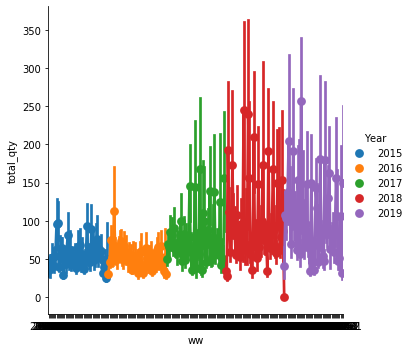

In [52]:
sns.factorplot(x ='ww', y ='total_qty',  
               hue = 'Year', data = df)

In [53]:
df.describe()

,Year,Month,Day,total_qty,total_amount,gdp_value,pmi_value,ww,dayofweek,mth_avg_qty,...,year2_min_qty,Qtr,quarter_avg_qty,quarter_max_qty,quarter_min_qty,week_avg_diff,mth12_avg_diff,mth23_avg_diff,mth13_avg_diff,year_avg_diff
count,339050.000000,339050.000000,339050.000000,339050.000000,3.390500e+05,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,...,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000,339050.000000
mean,2016.703575,6.354741,14.563498,70.219286,4.686262e+03,72121.275089,48.620192,201696.128598,2.444256,36.587269,...,9.991871,2.448017,49.414731,120.981047,15.848544,-1.116048,-0.524548,3.504567,2.980018,20.215815
std,1.386191,3.485658,8.570391,489.127092,2.440614e+04,6331.039093,1.277900,139.440562,1.623480,342.896812,...,62.981290,1.139941,317.735726,1134.492495,113.004966,200.981271,312.751316,321.349848,324.482174,208.087742
min,2015.000000,1.000000,1.000000,1.000000,1.000000e-02,62217.000000,46.200000,201501.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,-21950.000000,-23000.000000,-20696.200000,-21620.000000,-6128.000000
25%,2015.000000,3.000000,7.000000,5.000000,4.950000e+02,66415.000000,47.600000,201552.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,6.000000,14.000000,12.000000,1.341800e+03,72260.000000,48.600000,201701.000000,2.000000,0.000000,...,0.000000,2.000000,4.148148,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,9.000000,22.000000,39.000000,3.714000e+03,77680.000000,49.500000,201814.000000,4.000000,10.000000,...,3.000000,3.000000,23.636364,35.000000,10.000000,0.000000,1.000000,1.000000,1.000000,7.692308
max,2019.000000,12.000000,31.000000,45807.000000,2.411388e+06,84114.000000,52.000000,202001.000000,6.000000,30000.000000,...,3600.000000,4.000000,12649.933333,45807.000000,12000.000000,15525.500000,21948.000000,21948.000000,30000.000000,9250.000000


In [54]:
df = df.drop(df[df.txn_date < pd.to_datetime(datetime.date(2016,6,1))].index)
# drop extra columns
df = df.drop(['invoice_id','txn_date','customer_id','product_id','mth_key','ww_n','ww_key','weeklag_key','year_key','quarter_key','mth_minus2key','mth_minus3key','mth_minus4key','mth_minus5key','mth_minus5key'], axis=1)

In [55]:
categorical_variables = list(df.select_dtypes(['object']).columns)
for var in categorical_variables:
    df[var] = df[var].astype(str)

In [56]:
df.dtypes

Year                      int64
Month                     int64
Day                       int64
total_qty               float64
total_amount            float64
customer_name            object
customer_city_name       object
customer_state_name      object
product_name             object
sub_brand_name           object
brand_name               object
product_company_name     object
gdp_value               float64
pmi_value               float64
state                    object
day_of_week              object
hoilday_states           object
holiday_type             object
ww                        int32
dayofweek                 int64
mth_avg_qty             float64
mth_max_qty             float64
mth_min_qty             float64
mth_minus2avg_qty       float64
mth_minus2max_qty       float64
mth_minus2min_qty       float64
mth_minus3avg_qty       float64
mth_minus3max_qty       float64
mth_minus3min_qty       float64
mth_minus4avg_qty       float64
mth_minus4max_qty       float64
mth_minu

In [57]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [58]:
multi = MultiColumnLabelEncoder(columns=categorical_variables)
df = multi.fit_transform(df)

# Identify the features with the most importance for the outcome variable Heart Disease

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# separate independent & dependent variables
important_features=['Day','Month','Year','total_qty','total_amount','customer_name','product_name','distributor_name']
X = df.drop(df[important_features],1)  #independent columns
y = df.total_qty    #target column i.e price range

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(35,'Score'))  #print 10 best features

featureScores = featureScores.sort_values(by='Score', ascending=False)

# selecting the 10 most impactful features for the target variable
features_list = featureScores["Specs"].tolist()[:20]
features_list

df_new=pd.concat([df[features_list], df[important_features]],1)

# split data
years = [2016,2017,2018,2019]
df_new = df_new[df_new.Year.isin(years)]
#df = df[df['Year']==2019]
test =df_new[(df_new.Year==2019) & (df_new.Month>6)]
train = df_new[~df_new.index.isin(test.index)]
#train=df[(df.Year<2019) & (df.Month>6)]
X_train = train.drop(['total_amount','total_qty'],1)
y_train = train.total_qty
X_test = test.drop(['total_amount','total_qty'],1)
y_test = test.total_qty

In [59]:
# split data
#years = [2016,2017,2018,2019]
years = [2016,2017,2018,2019]
df = df[df.Year.isin(years)]
#df = df[df['Year']==2019]
test =df[(df.Year==2019) & (df.Month>6)]
train = df[~df.index.isin(test.index)]
#train=df[(df.Year<2019) & (df.Month>6)]
X_train = train.drop(['total_amount','total_qty'],1)
y_train = train.total_qty
X_test = test.drop(['total_amount','total_qty'],1)
y_test = test.total_qty

In [60]:
%%time
import xgboost as xgb
xgboost = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=100, random_state=123
)
xgboost.fit(X_train,y_train)

Wall time: 35.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Save model

In [61]:
# Let's save this model fit out
import joblib
os.makedirs("outputs", exist_ok=True)
joblib.dump(value=xgboost, filename="outputs/AZ-sales.pkl")

['outputs/AZ-sales.pkl']

## Register model into workspace

In [62]:
#Let's register this model with our workspace

from azureml.core.model import Model

#model = Model.register(workspace=workspace, model_path="outputs/AZ-sales.pkl", model_name="AZ-sales")
model = Model.register(workspace=workspace, model_path="AZ-sales.pkl", model_name="AZ-sales")

Registering model AZ-sales


from sklearn.externals import joblib
import numpy as np

run_model = joblib.load('AZ-sales.pkl')
run_model.predict(a)

In [63]:
mymodel = Model(workspace=workspace, name="AZ-sales")
mymodel.download(exist_ok=True)

'AZ-sales.pkl'

mymodel.delete()

## Reference model

In [64]:
print(Model.get_model_path('AZ-sales',1,workspace))
print("______________________________")

azureml-models\AZ-sales\1\AZ-sales.pkl
______________________________


## Build an entry script

In [65]:
%%writefile score.py
# Now we build an entry script that uses our model reference:

import json
import pickle
import numpy as np
import pandas as pd
#from sklearn.externals import joblib
import joblib
from azureml.core.model import Model
#import xgboost as xgb


def init():
    global model
    model_path = Model.get_model_path('AZ-sales')
    model = joblib.load(model_path)
    
        
def run(data):
    data = np.array(json.loads(data)['data'])
    a=pd.DataFrame(data.reshape(-1,58),columns=['Year', 'Month', 'Day', 'customer_name', 'customer_city_name',
       'customer_state_name', 'product_name', 'sub_brand_name', 'brand_name',
       'product_company_name', 'gdp_value', 'pmi_value', 'state',
       'day_of_week', 'hoilday_states', 'holiday_type', 'ww', 'dayofweek',
       'mth_avg_qty', 'mth_max_qty', 'mth_min_qty', 'mth_minus2avg_qty',
       'mth_minus2max_qty', 'mth_minus2min_qty', 'mth_minus3avg_qty',
       'mth_minus3max_qty', 'mth_minus3min_qty', 'mth_minus4avg_qty',
       'mth_minus4max_qty', 'mth_minus4min_qty', 'mth_minus5avg_qty',
       'mth_minus5max_qty', 'mth_minus5min_qty', 'ww1_avg_qty', 'ww1_max_qty',
       'ww1_min_qty', 'week2', 'week2_key', 'week2_avg_qty', 'week2_max_qty',
       'week2_min_qty', 'weeklag_qty', 'year_avg_qty', 'year_max_qty',
       'year_min_qty', 'year2_key', 'year2_avg_qty', 'year2_max_qty',
       'year2_min_qty', 'Qtr', 'quarter_avg_qty', 'quarter_max_qty',
       'quarter_min_qty', 'week_avg_diff', 'mth12_avg_diff', 'mth23_avg_diff',
       'mth13_avg_diff', 'year_avg_diff'])
    result = model.predict(a)
    return result.tolist()


Overwriting score.py


In [66]:
print(Model.list(workspace))

[Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:36, version=36, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:35, version=35, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:34, version=34, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:33, version=33, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:32, version=32, tags={}, properties={}), Model(wor

In [67]:
import json
import pickle
import numpy as np
import pandas as pd
import joblib
from azureml.core.model import Model

import random
l = [random.randint(0,10) for i in range(58)]

sample = json.dumps({"data": l})

my_array = np.array(json.loads(sample)['data'])

a=pd.DataFrame(np.array(l).reshape(-1,58),columns=X_test.columns)

print(Model.list(workspace))
model_path = Model.get_model_path(model_name = 'AZ-sales')
print(model_path)

local_model = joblib.load(model_path)
print("local_model: ", local_model.predict(a))


def run(data):
    data = np.array(json.loads(data)['data'])
    a=pd.DataFrame(data.reshape(-1,58),columns=X_test.columns)
    result = local_model.predict(a)
    return result.tolist()
    
#print("local_model_through_run_function: ", run(sample))  

[Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:36, version=36, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:35, version=35, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:34, version=34, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:33, version=33, tags={}, properties={}), Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:32, version=32, tags={}, properties={}), Model(wor

In [68]:
run(sample)

[51.764774322509766]

## Build Dependency list and save it as a yaml file.

In [69]:
from azureml.core.conda_dependencies import CondaDependencies

dependencies = CondaDependencies()
dependencies.set_python_version("3.7.6")
dependencies.add_conda_package('pandas')
dependencies.add_conda_package('scikit-learn')
dependencies.add_conda_package('numpy')
dependencies.add_conda_package('ruamel')
dependencies.add_conda_package('ruamel.yaml')
dependencies.add_pip_package("scikit-learn==0.22.1")
dependencies.add_pip_package("scikit-learn==0.22.1")
dependencies.add_pip_package("numpy==1.18.1")
dependencies.add_pip_package("pandas==1.0.1")
dependencies.add_pip_package("matplotlib==3.1.3")
dependencies.add_pip_package("xgboost==1.1.1")
dependencies.add_pip_package('pip==20.2.2')
dependencies.add_pip_package('joblib==0.14.1')
dependencies.add_pip_package("azureml-sdk == 1.12.0")
dependencies.add_pip_package('ruamel.yaml==0.15.87')
dependencies.save_to_file(".","myenv.yml")

'myenv.yml'

In [70]:
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.image import ContainerImage

## Define deployment configuration and container image

In [71]:
# Define the configuration of compute: ACI with 1 cpu core and 1 gb of memory.
aci_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 8)
aci_config

In [72]:
# Build a container image
image_config = ContainerImage.image_configuration(execution_script = "score.py", 
                                   runtime = "python", 
                                   conda_file = "myenv.yml")
image_config

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ContainerImage class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  after removing the cwd from sys.path.


# Deployment Using Local Webservice

from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import LocalWebservice

#### Create inference configuration based on the environment definition and the entry script
myenv = Environment.from_conda_specification(name="env", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script="score.py", environment=myenv)

#### Create a local deployment, using port 8890 for the web service endpoint
deployment_config = LocalWebservice.deploy_configuration(port=8890)

#### Deploy the service
service = Model.deploy(workspace, "mymodel", [model], inference_config,deployment_config)

#### Wait for the deployment to complete
service.wait_for_deployment(True)

#### Display the port that the web service is available on
print(service.port)

In [73]:
# Deploy the web service as an image containing the registered model.

service = Webservice.deploy_from_model(name = "az-sales-webservice",
                                        deployment_config = aci_config,
                                        models = [model],
                                        image_config = image_config,
                                        workspace = workspace)

# The service deployment can take several minutes: wait for completion.
service.wait_for_deployment(show_output = True)
print(service.state)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: deploy_from_model has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  import sys


Creating image
Running................................................................................
Succeeded
Image creation operation finished for image az-sales-webservice:44, operation "Succeeded"
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.......................
Succeeded
ACI service creation operation finished, operation "Succeeded"


from azureml.core import Model
for model in Model.list(workspace):
    print('name:', model.name, '\nversion:', model.version, '\n')
Model(workspace, name = 'model.name', version = 'model.version').delete()

from azureml.core import Webservice
for webservice in Webservice.list(ws):
    print('name:', webservice.name)
Webservice(ws, name = 'webservice').delete()

In [81]:
import json
import pickle
import numpy as np
import pandas as pd
import joblib
from azureml.core.model import Model

import random
l = [random.randint(0,10) for i in range(58)]

sample = json.dumps({"data": l})
#print(sample)
#print(type(sample))
#print(json.loads(sample)['data'])
my_array = np.array(json.loads(sample)['data'])
#print(my_array.shape)
#my2d_array = my_array.reshape(-1,1)
#print(my2d_array)
#print(my2d_array.shape)
##test_samples = bytes(test_samples, encoding='utf8')
a=pd.DataFrame(np.array(l).reshape(-1,58),columns=X_test.columns)

print(Model.list(workspace))
model_path = Model.get_model_path(model_name = 'AZ-sales')
print(model_path)

local_model = joblib.load(model_path)
print("local_model: ", local_model.predict(a))


def run(data):
    data = np.array(json.loads(data)['data'])
    a=pd.DataFrame(data.reshape(-1,58),columns=X_test.columns)
    result = local_model.predict(a)
    return result.tolist()

result=service.run(sample)
print("from aci deployment: ", result)
    
#print("local_model_through_run_function: ", run(sample))  

[Model(workspace=Workspace.create(name='ProductML', subscription_id='9d86bb9e-5ee7-4865-82f0-b658cd30da1b', resource_group='MCC'), name=AZ-sales, id=AZ-sales:36, version=36, tags={}, properties={})]
azureml-models\AZ-sales\1\AZ-sales.pkl
local_model:  [51.454437]
from aci deployment:  [51.454437255859375]


In [ ]:
print(service.get_logs())

In [ ]:
# Check core SDK version number
import azureml.core
print("SDK version:", azureml.core.VERSION)